In [2]:
import pandas as pd
import numpy as np
import logging
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Load Preprocessed Data
train_df = pd.read_csv("cleaned_stock_data_train.csv")
test_df = pd.read_csv("cleaned_stock_data_test.csv")

C:\Users\Samir\AppData\Local\Temp\ipykernel_11380\3524613748.py:18: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("cleaned_stock_data_train.csv")
C:\Users\Samir\AppData\Local\Temp\ipykernel_11380\3524613748.py:19: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv("cleaned_stock_data_test.csv")


In [3]:
# Standardize column names
train_df.columns = train_df.columns.str.strip().str.lower().str.replace(' ', '_')
test_df.columns = test_df.columns.str.strip().str.lower().str.replace(' ', '_')

In [4]:
# Convert Categorical Columns to Numeric
categorical_cols = train_df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    combined_data = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(combined_data)
    
    train_df[col] = le.transform(train_df[col].astype(str))
    
    # Create a mapping dictionary for test_df transformation
    mapping_dict = {label: index for index, label in enumerate(le.classes_)}
    test_df[col] = test_df[col].astype(str).map(mapping_dict).fillna(-1).astype(int)
    
    label_encoders[col] = le

In [5]:
# Ensure all categorical columns are converted to integers
test_df[categorical_cols] = test_df[categorical_cols].astype(int)
train_df[categorical_cols] = train_df[categorical_cols].astype(int)

In [6]:
# Identify the correct adjusted close column
adj_close_col = [col for col in train_df.columns if 'adj' in col.lower() and 'close' in col.lower()]
if not adj_close_col:
    raise KeyError("❌ No column found for adjusted close price!")
adj_close_col = adj_close_col[0]  # Take the first match

In [7]:

# **Feature Engineering: Moving Averages, Volatility, RSI, and Momentum**
logging.info("Applying feature engineering...")


2025-03-06 17:10:50,977 - INFO - Applying feature engineering...


In [8]:
# Moving Averages
train_df["MA_5"] = train_df[adj_close_col].rolling(window=5, min_periods=1).mean()
train_df["MA_20"] = train_df[adj_close_col].rolling(window=20, min_periods=1).mean()

test_df["MA_5"] = test_df[adj_close_col].rolling(window=5, min_periods=1).mean()
test_df["MA_20"] = test_df[adj_close_col].rolling(window=20, min_periods=1).mean()


In [9]:
# Volatility (Standard Deviation over 10 days)
train_df["volatility_10"] = train_df[adj_close_col].rolling(window=10, min_periods=1).std()
test_df["volatility_10"] = test_df[adj_close_col].rolling(window=10, min_periods=1).std()


In [10]:
# Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / (loss + 1e-9)
    return 100 - (100 / (1 + rs))

train_df["RSI_14"] = compute_rsi(train_df[adj_close_col])
test_df["RSI_14"] = compute_rsi(test_df[adj_close_col])

In [11]:
# Exponential Moving Averages (EMA)
train_df["EMA_10"] = train_df[adj_close_col].ewm(span=10, adjust=False).mean()
train_df["EMA_20"] = train_df[adj_close_col].ewm(span=20, adjust=False).mean()
test_df["EMA_10"] = test_df[adj_close_col].ewm(span=10, adjust=False).mean()
test_df["EMA_20"] = test_df[adj_close_col].ewm(span=20, adjust=False).mean()


In [12]:
# Fill missing values
train_df.fillna(method="bfill", inplace=True)
test_df.fillna(method="bfill", inplace=True)


C:\Users\Samir\AppData\Local\Temp\ipykernel_11380\427938789.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df.fillna(method="bfill", inplace=True)
C:\Users\Samir\AppData\Local\Temp\ipykernel_11380\427938789.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df.fillna(method="bfill", inplace=True)


In [13]:
# **Create Classification Target Variable: Price Up (1) / Down (0)**
train_df['price_movement'] = (train_df[adj_close_col].shift(-1) > train_df[adj_close_col]).astype(int)
test_df['price_movement'] = (test_df[adj_close_col].shift(-1) > test_df[adj_close_col]).astype(int)


In [14]:
# Define Features and Target
target = 'price_movement'
features = [col for col in train_df.columns if col not in ['ticker', 'date', 'close', adj_close_col, 'price_movement']]


In [15]:
# **Feature Scaling**
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[features])
X_test = scaler.transform(test_df[features])

y_train = train_df[target]
y_test = test_df[target]


In [16]:
# Initialize Classification Models
models = {
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.05, 
        objective='binary:logistic', n_jobs=-1, enable_categorical=True
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.05, 
        n_jobs=-1
    )
}

results = {}

2025-03-06 17:13:31,551 - INFO - Training XGBoost model...
2025-03-06 17:14:12,825 - INFO - XGBoost Performance:
 Accuracy: 0.5543 | ROC-AUC: 0.5303


🔹 XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.78      0.66    583022
           1       0.51      0.28      0.36    481681

    accuracy                           0.55   1064703
   macro avg       0.54      0.53      0.51   1064703
weighted avg       0.54      0.55      0.52   1064703



C:\Users\Samir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


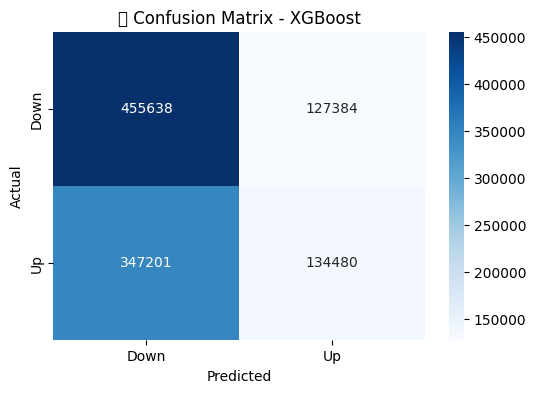

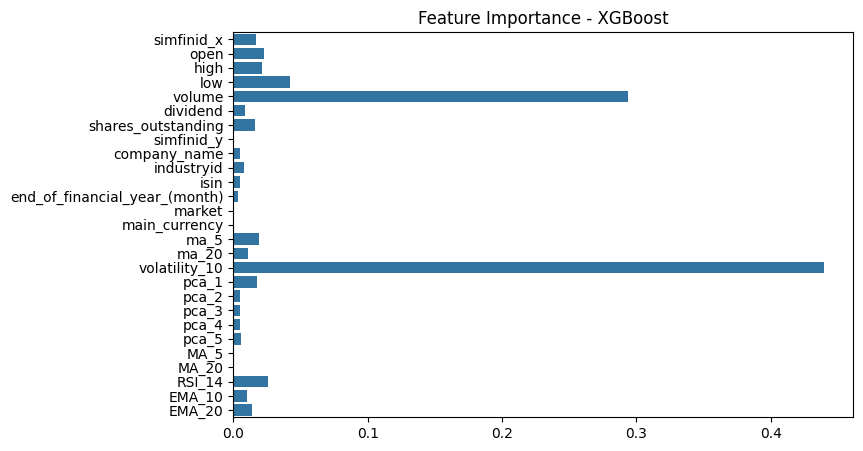

2025-03-06 17:14:14,087 - INFO - Training LightGBM model...


[LightGBM] [Info] Number of positive: 1925321, number of negative: 2333489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5720
[LightGBM] [Info] Number of data points in the train set: 4258810, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452080 -> initscore=-0.192272
[LightGBM] [Info] Start training from score -0.192272


C:\Users\Samir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025-03-06 17:14:50,077 - INFO - LightGBM Performance:
 Accuracy: 0.5542 | ROC-AUC: 0.5311
C:\Users\Samir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


🔹 LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.77      0.66    583022
           1       0.51      0.29      0.37    481681

    accuracy                           0.55   1064703
   macro avg       0.54      0.53      0.51   1064703
weighted avg       0.54      0.55      0.53   1064703



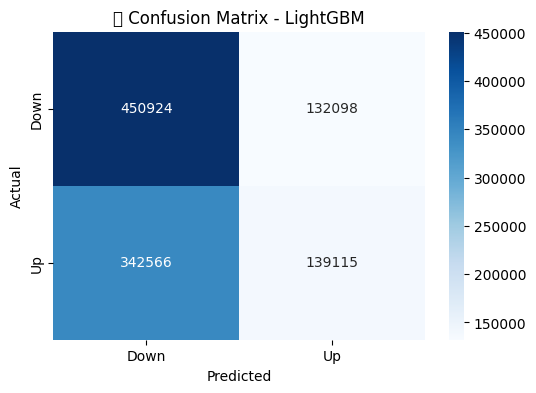

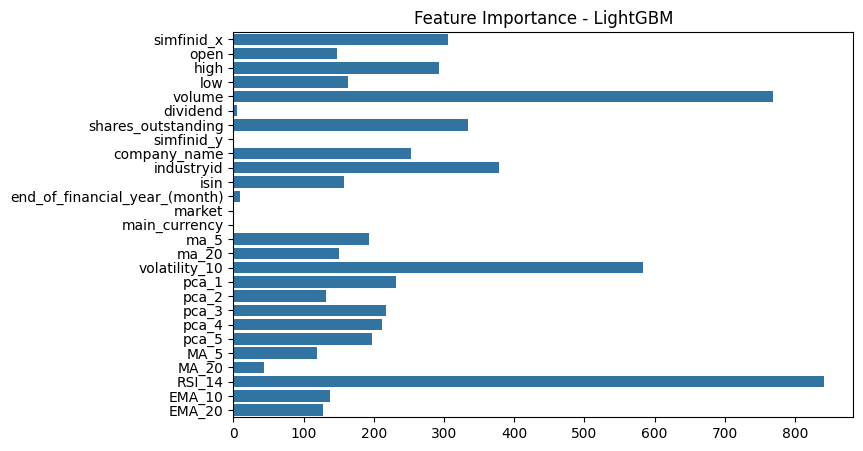


Model Comparison:


,Accuracy,ROC-AUC
XGBoost,0.554256,0.530350
LightGBM,0.554182,0.531118


In [17]:
# Train and Evaluate Models
for name, model in models.items():
    logging.info(f"Training {name} model...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    # Compute Metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {"Accuracy": accuracy, "ROC-AUC": roc_auc}
    logging.info(f"{name} Performance:\n Accuracy: {accuracy:.4f} | ROC-AUC: {roc_auc:.4f}")
    
    # Display Classification Report
    print(f"🔹 {name} Classification Report:\n", report)

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"📊 Confusion Matrix - {name}")
    plt.show()

    # Feature Importance
    feature_importance = model.feature_importances_
    plt.figure(figsize=(8, 5))
    sns.barplot(x=feature_importance, y=features)
    plt.title(f"Feature Importance - {name}")
    plt.show()

    # Save Model
    joblib.dump(model, f"{name.lower()}_model.pkl")

# Display Results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
display(results_df)